# Assignment 6

**Submission deadline:**

* **Last labs during the semester**


**Points: 8 bonus points**


## Downloading this notebook

The assignment is in the form of a Jupyter notebook. We will be using Google Colab to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using Google Colab.

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [0]:
from __future__ import division
from __future__ import print_function

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e  word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /content/word2vec.tar.xz
395MB [00:01, 200MB/s]


In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1: Word Embeddings [4p bonus]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [0]:
import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import tabulate

def load_vecs(base_path):
    vec = np.load(base_path + '.npy')
    vocab = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(vocab)}
    return vec, vocab, word2idx

def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [0]:
# Load top 20k word embeddings: Word2vec and FastText
(word2vec, word2vec_vocab, word2vec_word2idx
) = load_vecs('word2vec/word2vec_GoogleNews_200k')

(ftext, ftext_vocab, ftext_word2idx
) = load_vecs('word2vec/fasttext_wikien_200k')

In [0]:
from numpy import linalg as LA

def eval_analogies(word_vecs, words, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: float32 array with shape num_words x dim
        words: list of strings with size num_words
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    word2idx = {w:i for i,w in enumerate(words)}
    indexes = [[word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    step = 500
    ind = indexes.shape[0]
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = word_vecs[indexes[:, 0]]
    q2 = word_vecs[indexes[:, 1]]
    r1 = word_vecs[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]
    r2 = np.array(r1 + q2 - q1)
    
    def cosin (u,v):
        v_norm = LA.norm(v, axis=1, keepdims=True)
        u_norm = LA.norm(u, axis=0, keepdims=True)
        distance = 1- (np.dot(v,u)/v_norm/u_norm)
        return np.argmin(distance, axis=1) 
    
    r2_pred_inds = []
    for i in arange(0, ind, step):
        v = r2[i:i+step]
        u = word_vecs.T
        r2_pred_inds.append(cosin(u,v))
    
    r2_pred_inds = np.concatenate(r2_pred_inds, axis=0)
    #distance.cdist(r2, word_vecs, metric='cosine')
    
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [0]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[3])
print(analogies_lower[3])

['Athens', 'Greece', 'Berlin', 'Germany']
['athens', 'greece', 'berlin', 'germany']


In [0]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
print(eval_analogies(ftext, ftext_vocab, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
print(eval_analogies(word2vec, word2vec_vocab, analogies), '% correct')
print(eval_analogies(word2vec, word2vec_vocab, analogies_lower), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.3748712667 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.8592876537 % correct
Got vocab for 9574/19544 pairs
14.3304783789 % correct


In [0]:
import gensim, logging

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = [['first', 'sentence'], ['second', 'sentence']]

model = gensim.models.Word2Vec(sentences, min_count=1)

2019-01-22 20:47:45,776 : INFO : collecting all words and their counts
2019-01-22 20:47:45,778 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-22 20:47:45,780 : INFO : collected 3 word types from a corpus of 4 raw words and 2 sentences
2019-01-22 20:47:45,783 : INFO : Loading a fresh vocabulary
2019-01-22 20:47:45,785 : INFO : effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
2019-01-22 20:47:45,786 : INFO : effective_min_count=1 leaves 4 word corpus (100% of original 4, drops 0)
2019-01-22 20:47:45,787 : INFO : deleting the raw counts dictionary of 3 items
2019-01-22 20:47:45,790 : INFO : sample=0.001 downsamples 3 most-common words
2019-01-22 20:47:45,791 : INFO : downsampling leaves estimated 0 word corpus (5.7% of prior 4)
2019-01-22 20:47:45,793 : INFO : estimated required memory for 3 words and 100 dimensions: 3900 bytes
2019-01-22 20:47:45,794 : INFO : resetting layer weights
2019-01-22 20:47:45,796 : INFO : training mo

## Subtask 2: translation through alignment of vector spaces

In [0]:
# We're gonna need Polish embeddings
(ftext_pl, ftext_pl_vocab, ftext_pl_word2idx
) = load_vecs('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext_word2idx and pl in ftext_pl_word2idx}



print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])


Dictionary size: 750
good -- dobro


In [0]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext[[ftext_word2idx[w] for w in en_words]]
V_pl = ftext_pl[[ftext_pl_word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [0]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error

# Hint: use scipy.linalg import orthogonal_procrustes
from scipy.linalg import orthogonal_procrustes

W, s = orthogonal_procrustes(V_en, V_pl)

In [0]:
def translate(W, v, vecs2, vocab2):
    
    transorm = np.dot(v,W)
    idx = np.argmin(distance.cdist(np.array([transorm]), vecs2, metric='cosine'))
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    return vocab2[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if not en_pl.has_key(ftext_vocab[i])]
tr_words = tr_words[:20]

rows = [[ftext_vocab[i], translate(W, ftext[i], ftext_pl, ftext_pl_vocab)] \
         for i in tr_words] 
print(tabulate.tabulate(rows).encode('utf-8'))

-----------  ----------
nor          nie
necessary    potrzebny
draft        elita
required     wymagano
doctor       doktor
voice        głosowy
answer       pytanie
angeles      czejanda
recording    nagraniowy
unless       jeśli
check        sprawdzić
jones        frazer
·            rozmowa
imperial     cesarska
corporation  firma
approach     podejście
overlaps     rozmawia
pop          pop/rock
regarding    odnośnie
missing      brakuje
-----------  ----------


## Subtask 3: PCA

In [0]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec_word2idx and v in word2vec_word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs [u'Canada', u'Ottawa', u'Turkmenistan', u'Ashgabat', u'Lithuania', u'Vilnius']


In [0]:
geo_inds = [word2vec_word2idx[w] for w in geo]
geo_vecs = word2vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


In [0]:
!pip install mkl

In [0]:
from sklearn.decomposition import PCA



#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
figsize(15,15)

pca = PCA(n_components=2)
res = pca.fit_transform(geo_vecs)



## Subtask 4: PCA vs t-SNE on frequent words

In [0]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext_vocab) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext_word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#
pca = PCA(n_components=2)
pca.fit(geo_vecs)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

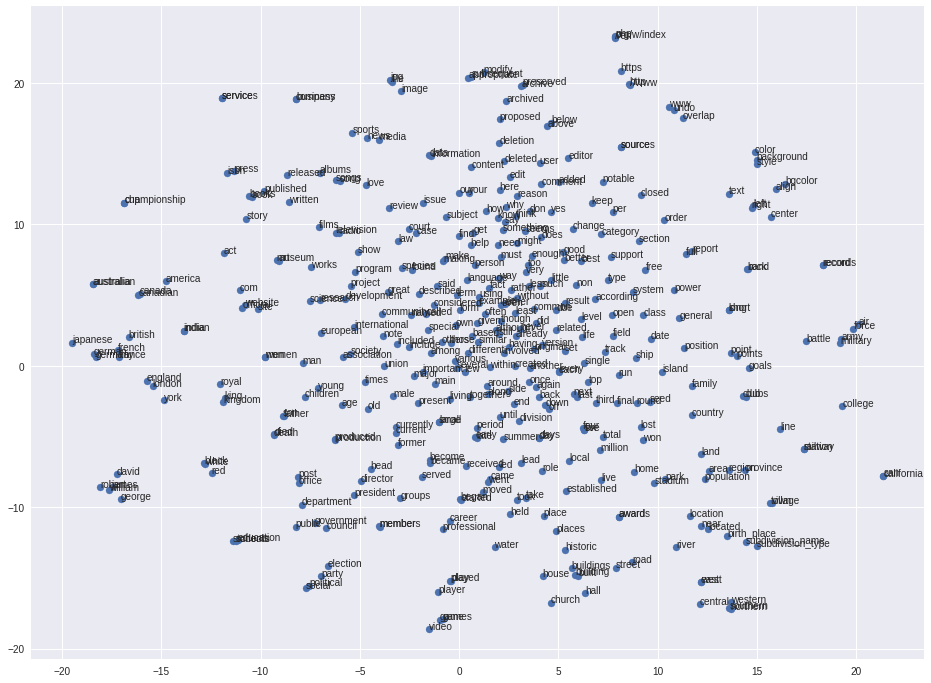

In [0]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
#


# Problem 2: K-Means [2p bonus]

Fill in the blanks in the K-means code. Then compare the following 3 strategies for initial point selection

1. Uniform sampling over the range of the data
2. Uniform sampling of data points
3. Kmeans++ (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf, pg. 3):
    1. the first point is sampled uniformly from the dataset
    2. subsequent points are sampled with probability $\frac{D(x)^2}{\sum_{x'} D(x')^2}$, where $D(x)$ denotes the distance from $x$ to a nearest point that was already chosen. 
    
Conduct experiments for various number of clusters and different initialization strategies. Make screenshots of some representative solutions (and failure modes).

Make one cluster of the generated data much 3-5 times larger. How does it affect the K-means solution?

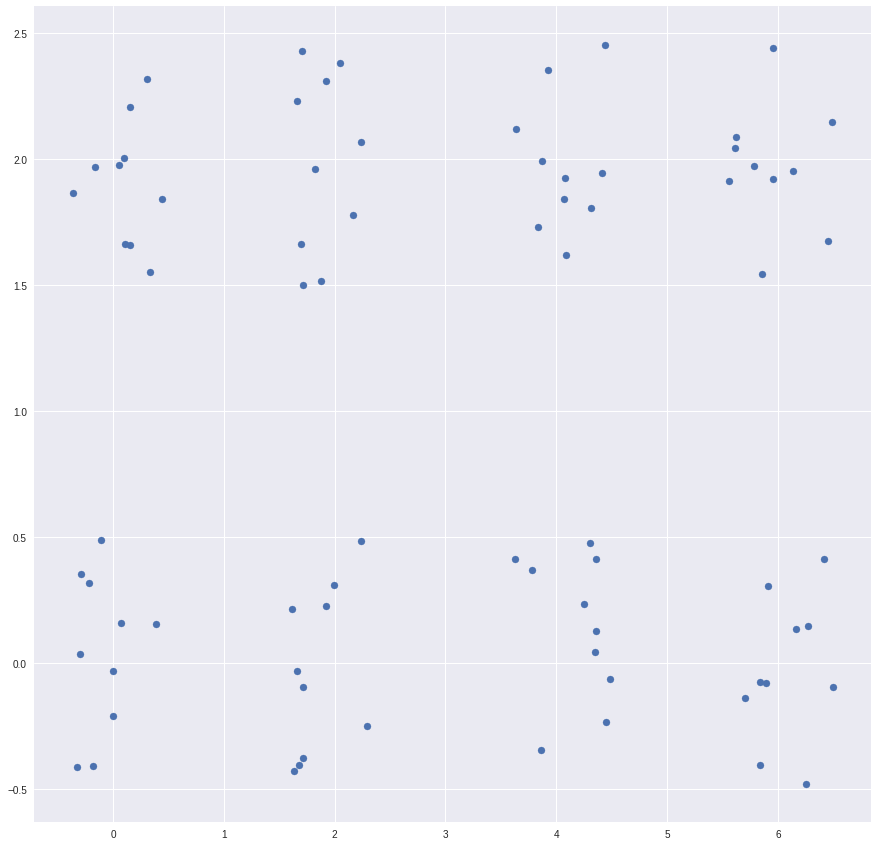

In [0]:
def gen_cluster(x0, y0, n=20):
    return np.random.rand(2,n) + np.array([[x0],[y0]]) - 0.5

def gen_data():
    clusters = []

    for x in [0,2,4,6]:
        for y in [0,2]:
            n = 10
            clusters.append(gen_cluster(x,y,n))

    return np.hstack(clusters)

data = gen_data()
scatter(data[0,:], data[1,:])

In [0]:
def dist(X,Y):
    dd = X[:,None,:] - Y[:,:,None]
    dd = (dd**2).sum(0)
    return dd

In [0]:
def k_means(data, k, init_pts='rand_samples'):
    dim, ns = data.shape
    
    if init_pts == 'rand_samples':
        indexes = np.random.randint(0, ns, size=k)
        C = data[:, indexes]
    elif init_pts == 'rand_range':
        C = np.zeros((dim,k))
        C[0,:] = np.random.uniform(data[0].min(), data[0].max(), size=k)
        C[1,:] = np.random.uniform(data[1].min(), data[1].max(), size=k)
    elif init_pts == 'km++':
        sampled_indexes = []
        C = np.zeros((dim, k))
        idx = np.random.randint(0, ns)
        sampled_indexes.append(idx)
        C[:, 0] = data[:, idx]
        for i in range(1, k):
            D = dist(data ,data[:,sampled_indexes]).min(0) ** 2
            D[np.asarray(sampled_indexes)] = 0 # zero probability for sampled points
            D = D/D.sum()
            idx = np.argmax(np.random.multinomial(1, D))
            sampled_indexes.append(idx)
            C[:, i] = data[:, idx]
    else:
        raise Exception('invalid init_pts!')
    
    Cinit = C.copy()
    last_assignments = np.zeros((ns,))
    while True:
        D = dist(data, C)
        assignment = argmin(D, axis=0)


        for ci in xrange(k):
            sel = assignment==ci
            if sum(sel) == 0:
                print('empty cluster: ', ci, '!')
                C[:,ci] = np.inf
            else:
                C[:,ci] = np.mean(data[:, np.array(sel)], axis=1)
        if np.all(assignment == last_assignments):
            break
        last_assignments = assignment
    
    return assignment, C, Cinit

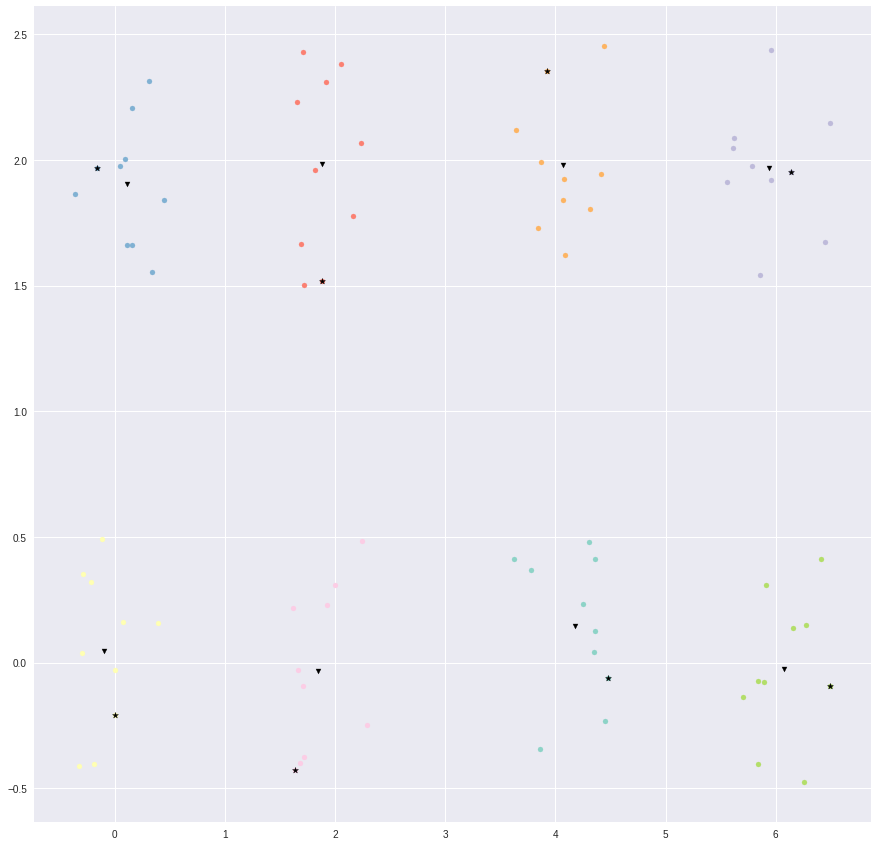

In [0]:
colormap = [
    (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    (1.0, 1.0, 0.7019607843137254),
    (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    (0.9882352941176471, 0.803921568627451, 0.8980392156862745)]


a, c, cinit = k_means(data, 8, init_pts='km++')

for ci in set(a):
    scatter(data[0,a==ci],data[1,a==ci], color=colormap[ci], s=25)

scatter(cinit[0,:], cinit[1,:], color='k',marker='*', s=40)
scatter(c[0,:], c[1,:], color='k',marker='v', s=25)

# Problem 3: Bisecting K-Means [2p bonus]

Implement the "Bisecting k-means" algorithm, such as the one from Apache Spark: https://spark.apache.org/docs/1.6.0/api/java/org/apache/spark/mllib/clustering/BisectingKMeans.html.